In [1]:
from google.colab import drive
drive.mount('/content/drive')
import os
os.chdir ("/content/drive/MyDrive/FourthBrain/Capstone Samsung OCT/Data/OCT2017")

Mounted at /content/drive


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
train_dir = os.getcwd() + "/train/"
valid_dir = os.getcwd() + "/val/"
test_dir = os.getcwd() + "/test/"

In [4]:
classes = ['NORMAL', 'CNV', 'DME', 'DRUSEN']
cols = [x.lower() for x in classes]
dirs = [train_dir, valid_dir, test_dir]
label = {0: 'normal', 1: 'cnv', 2: 'dme', 3: 'drusen'}

REGEN = False # if we should read the directory structre, if False then use the CSV files already saved

In [5]:
def create_df (path, classes=classes):
  df = pd.DataFrame(columns=['filename', 'normal', 'cnv', 'dme', 'drusen'])
  for sub_dir in classes:
    condition = {'normal': 0, 'cnv': 0, 'dme':0, 'drusen': 0}
    files = os.listdir(path + sub_dir)
    if (sub_dir== 'NORMAL'):
      condition['normal'] = 1
    elif (sub_dir == 'CNV'):
      condition['cnv'] = 1
    elif (sub_dir == 'DME'):
      condition['dme'] = 1
    else:
      condition['drusen']= 1
    for f in files:
      df = df.append({'filename': path +  sub_dir  + "/" + f, 
                      'normal': condition['normal'], 
                      'cnv': condition['cnv'],
                      'dme': condition['dme'],
                      'drusen': condition['drusen']}, ignore_index=True)
  return df

In [6]:
# Generting the DataFrames of the filenames
# this is primarily used so we can sub-sample files easier for the different training strategies
if (REGEN):
  train_df = create_df(train_dir)
  valid_df = create_df(valid_dir)
  test_df = create_df(test_dir)
  train_df.to_csv("train_data.csv")
  valid_df.to_csv("valid_data.csv")
  test_df.to_csv("test_data.csv")
else:
  train_df = pd.read_csv("train_data.csv")
  valid_df = pd.read_csv("valid_data.csv")
  test_df = pd.read_csv("test_data.csv")

In [7]:
print ("Training Data: ", train_df.shape)
print ("Validation Data: ", valid_df.shape)
print ("Test Data: ", test_df.shape)

Training Data:  (83484, 6)
Validation Data:  (32, 6)
Test Data:  (968, 6)


In [8]:
# Printing out the # of samples for each subsample percentage 
print ("Trainig Data percentages:")
print (" 1% ==> ", int(.01 * train_df.shape[0]))
print (" 5% ==> ", int(.05 * train_df.shape[0]))
print ("10% ==> ", int(.1  * train_df.shape[0] ))
print ("25% ==> ", int(.25 * train_df.shape[0]))
print ("75% ==> ", int(.75 * train_df.shape[0]))
print ("90% ==> ", int(.9  * train_df.shape[0]))
print ("98% ==> ", int(.98 * train_df.shape[0]))

Trainig Data percentages:
 1% ==>  834
 5% ==>  4174
10% ==>  8348
25% ==>  20871
75% ==>  62613
90% ==>  75135
98% ==>  81814


In [9]:
# Sampling 1% of the data
sample = train_df.sample(frac=0.5, random_state=10, axis=0)
sample.shape

(41742, 6)

In [9]:
# determine class weights to feed into neural network during training
def get_classweight(df):
  total = df.shape[0]
  num_norm = df['normal'].sum()
  num_cnv = df['cnv'].sum()
  num_dme = df['dme'].sum()
  num_drusen = df['drusen'].sum()
  norm_weight = (1/num_norm) * (total/4)
  norm_cnv = (1/num_cnv) * (total/4)
  norm_dme = (1/num_dme) * (total/4)
  norm_drusen = (1/num_drusen) * (total/4)
  class_weight = {0 : norm_weight, 1: norm_cnv,
                  2 : norm_dme, 3: norm_drusen}
  return class_weight

In [11]:
class_weight = get_classweight(sample)
class_weight

{0: 0.7970289467654471,
 1: 0.5620152951314089,
 2: 1.8126628452318918,
 3: 2.413390379278446}

In [10]:
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.applications as app
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_image_datagen = ImageDataGenerator(rotation_range=90, width_shift_range=[-.1,.1], height_shift_range=[-.1,.1],
                                         shear_range=0.25, zoom_range=0.3, horizontal_flip=True,
                                         vertical_flip=True, rescale = 1./255., validation_split=.2)

# Setting the imgages to come from the dataframe where we specify the filenames and columns to use for "labels"
train_imgs = train_image_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=32, seed=10, subset='training')
valid_imgs = train_image_datagen.flow_from_directory(train_dir, target_size=(224,224), batch_size=16, seed=10, subset='validation')

Found 15972 images belonging to 4 classes.
Found 9255 images belonging to 4 classes.


In [14]:
pre_process = keras.applications.densenet.preprocess_input
base_model = app.densenet.DenseNet121 (include_top=False, weights="imagenet", input_shape=(224,224,3), pooling=None)
base_model.trainable = False

# This is a must for Densenet as per documenatation, otherwise you get all kinds of errors when building model
input = keras.layers.Input(shape=(224,224,3))
x = pre_process(input)

# Creating DenseNet model
x = base_model(x)

#Layers added to Densenet
'''
y = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(x)
y = keras.layers.BatchNormalization()(y)
x = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(y)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Concatenate()([x,y])
x = keras.layers.MaxPooling2D(2)(x)
y = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(x)
y = keras.layers.BatchNormalization()(y)
x = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(y)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Concatenate()([x,y])
x = keras.layers.MaxPooling2D(2)(x)
'''
y = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(x)
y = keras.layers.BatchNormalization()(y)
#x = keras.layers.Conv2D(512, 3, padding="same", activation="ReLU")(y)
#x = keras.layers.BatchNormalization()(x)
#x = keras.layers.Concatenate()([x,y])
y = keras.layers.GlobalAveragePooling2D()(y)
# Output layer for the 4 classes we are dealing with
output = keras.layers.Dense(4, activation="softmax")(y)

model = keras.Model(inputs=input, outputs=output)

model.summary()

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 224, 224, 3)       0         
_________________________________________________________________
densenet121 (Functional)     (None, 7, 7, 1024)        7037504   
_________________________________________________________________
conv2d (Conv2D)              (None, 7, 7, 512)         4719104   
______________________________________________________________

In [16]:
# This code did not work, it caused I/O Error 5:
# model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics='accuracy')
model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics='accuracy')

In [17]:
import datetime
%load_ext tensorboard
%reload_ext tensorboard

In [18]:
if not (os.path.exists('./logs/fit/')):
  os.mkdir('./logs/fit/')

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Creating a checkpoint to save the best model so that we can reload it once training is complete
checkpoint_cb = keras.callbacks.ModelCheckpoint("oct_densenet.h5", save_best_only=True)
# Adding an an early stop callback to avoid overfitting in case the model is not improving after 5 consescutive epochs
earlystop_cb = keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
# Tensorboard callback to view the training & validation curves
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [19]:
history = model.fit(train_imgs,  steps_per_epoch=40, epochs=100, verbose=1, validation_data=valid_imgs, 
                    class_weight=class_weight, callbacks=[checkpoint_cb]) #earlystop_cb]) # tensorboard_cb])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/100
40/40 [==============================] - 6256s 160s/step - loss: 1.7296 - accuracy: 0.3570 - val_loss: 1.5397 - val_accuracy: 0.3694
Epoch 2/100
40/40 [==============================] - 684s 17s/step - loss: 1.4558 - accuracy: 0.4125 - val_loss: 1.3789 - val_accuracy: 0.5406
Epoch 3/100
40/40 [==============================] - 694s 18s/step - loss: 1.4355 - accuracy: 0.4352 - val_loss: 1.3575 - val_accuracy: 0.4632
Epoch 4/100
40/40 [==============================] - 671s 17s/step - loss: 1.4316 - accuracy: 0.4625 - val_loss: 1.5193 - val_accuracy: 0.4596
Epoch 5/100
40/40 [==============================] - 656s 17s/step - loss: 1.3871 - accuracy: 0.4766 - val_loss: 1.6624 - val_accuracy: 0.4516
Epoch 6/100
40/40 [==============================] - 669s 17s/step - loss: 1.3894 - accuracy: 0.4828 - val_loss: 1.4236 - val_accuracy: 0.4725
Ep

In [12]:
sample_test = test_df.sample(frac=0.5, random_state=10, axis=0)
test_image_datagen = ImageDataGenerator( rescale = 1./255.)

test_imgs = test_image_datagen.flow_from_directory(test_dir, target_size=(224,224), batch_size=16)

Found 968 images belonging to 4 classes.


In [17]:
model.load_weights("oct_densenet.h5")
model.evaluate(test_imgs)

61/61 [==============================] - 669s 11s/step - loss: 1.3498 - accuracy: 0.4556


[1.349819302558899, 0.4555785059928894]

NameError: ignored

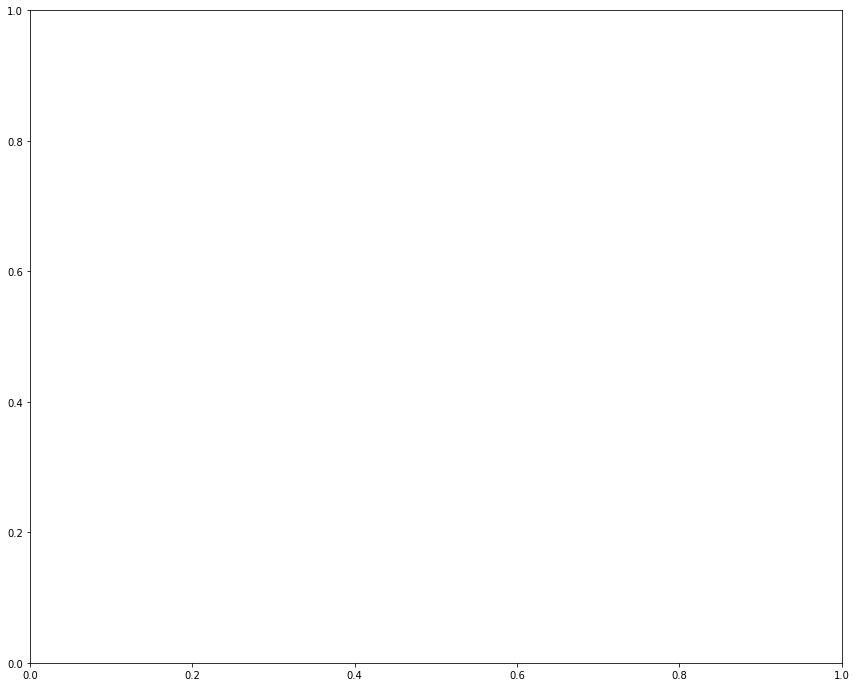

In [74]:
#Plotiting training results
plt.figure(figsize=(32,12))
plt.subplot(1,2,1)
plt.plot(range(len(history.history["loss"])), history.history['loss'], label="loss")
plt.plot(range(len(history.history["loss"])), history.history['val_loss'], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
plt.plot(range(len(history.history["loss"])), history.history["accuracy"], label="accuracy")
plt.plot(range(len(history.history["loss"])), history.history["val_accuracy"], label="val_accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()